In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

### Dataset

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [36]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5),
    A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(40, 40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Data visualization

### VGG

In [6]:
from torchvision.models import vgg16_bn

In [7]:
# ###### EVALUATE
# model.eval()
# running_valloss = 0.0
# running_valacc = 0.0
# for i,data in enumerate(test_loader):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs, labels = data
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     outputs = model(inputs)

#     loss = criterion(outputs, labels)
#     acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

#     running_valloss += (loss.item() * inputs.size(0))
#     running_valacc += acc.item()

# print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

NameError: name 'model' is not defined

In [25]:
class VGG(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        super(VGG, self).__init__()
        

        self.features = nn.Sequential(
                              nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
            
                              nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

                              nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                              nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                              nn.ReLU(inplace=True),

                              nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))

#                               nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#                               nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                               nn.ReLU(inplace=True),
#                               nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#                               nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                               nn.ReLU(inplace=True),

#                               nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))

#                               nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#                               nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                               nn.ReLU(inplace=True),
#                               nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#                               nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                               nn.ReLU(inplace=True),

#                               nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
                              nn.Linear(128, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
                              
                              nn.Linear(128, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
        
                              nn.Linear(128, out_channels, bias=True))
        
    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x


In [26]:
device = torch.device('cuda')
model = VGG().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [27]:
model_path = 'baseline_vgg_3blocks_model.pt'

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7467082738876343 Batch_id=224 Accuracy=0.21621621621621623: 100%|██████████| 225/225 [00:10<00:00, 20.68it/s]

- Avg.loss: 1.842 | Avg.acc: 0.232



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.786 | Avg. val_acc: 0.272
* Update optimal model
Epoch:  2


Loss=1.6211585998535156 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:11<00:00, 20.28it/s]

- Avg.loss: 1.691 | Avg.acc: 0.317



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.678 | Avg. val_acc: 0.339
* Update optimal model
Epoch:  3


Loss=1.4320374727249146 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:10<00:00, 20.46it/s]

- Avg.loss: 1.576 | Avg.acc: 0.374



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.566 | Avg. val_acc: 0.388
* Update optimal model
Epoch:  4


Loss=1.4319567680358887 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:11<00:00, 20.37it/s]

- Avg.loss: 1.486 | Avg.acc: 0.427



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.841 | Avg. val_acc: 0.340
Epoch:  5


Loss=1.5488255023956299 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:11<00:00, 20.33it/s]

- Avg.loss: 1.422 | Avg.acc: 0.452



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.453 | Avg. val_acc: 0.430
* Update optimal model
Epoch:  6


Loss=1.1075401306152344 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:10<00:00, 20.48it/s]

- Avg.loss: 1.365 | Avg.acc: 0.478



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.502 | Avg. val_acc: 0.437
* Update optimal model
Epoch:  7


Loss=1.2173097133636475 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 20.44it/s]

- Avg.loss: 1.334 | Avg.acc: 0.494



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.473 | Avg. val_acc: 0.442
* Update optimal model
Epoch:  8


Loss=1.0700159072875977 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:10<00:00, 20.58it/s]

- Avg.loss: 1.286 | Avg.acc: 0.512



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.468 | Avg. val_acc: 0.435
Epoch:  9


Loss=1.388288140296936 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:10<00:00, 20.49it/s]

- Avg.loss: 1.264 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.579 | Avg. val_acc: 0.386
Epoch:  10


Loss=1.0526164770126343 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:11<00:00, 20.23it/s]

- Avg.loss: 1.236 | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.498 | Avg. val_acc: 0.436
Epoch:  11


Loss=1.463863730430603 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:10<00:00, 20.46it/s]

- Avg.loss: 1.216 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.272 | Avg. val_acc: 0.498
* Update optimal model
Epoch:  12


Loss=1.5747289657592773 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 1.196 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198 | Avg. val_acc: 0.543
* Update optimal model
Epoch:  13


Loss=1.3220363855361938 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:11<00:00, 20.44it/s]

- Avg.loss: 1.175 | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.230 | Avg. val_acc: 0.524
Epoch:  14


Loss=1.3574274778366089 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:11<00:00, 20.33it/s]

- Avg.loss: 1.160 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  15


Loss=0.981170654296875 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 20.38it/s]

- Avg.loss: 1.147 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.539
Epoch:  16


Loss=1.3081899881362915 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:11<00:00, 20.25it/s]

- Avg.loss: 1.133 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.294 | Avg. val_acc: 0.503
Epoch:  17


Loss=1.2737882137298584 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:11<00:00, 20.43it/s]

- Avg.loss: 1.114 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.525
Epoch:  18


Loss=1.0938525199890137 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 19.91it/s]

- Avg.loss: 1.108 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.557
Epoch:  19


Loss=1.2043802738189697 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:11<00:00, 20.17it/s]

- Avg.loss: 1.087 | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.578
* Update optimal model
Epoch:  20


Loss=1.3506499528884888 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:11<00:00, 20.37it/s]

- Avg.loss: 1.075 | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.206 | Avg. val_acc: 0.538
Epoch:  21


Loss=1.3006592988967896 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 1.074 | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.279 | Avg. val_acc: 0.532
Epoch:  22


Loss=1.1740669012069702 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 1.057 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155 | Avg. val_acc: 0.557
Epoch:  23


Loss=1.2654013633728027 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:11<00:00, 20.22it/s]

- Avg.loss: 1.046 | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.579
* Update optimal model
Epoch:  24


Loss=1.071085810661316 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:11<00:00, 20.43it/s]

- Avg.loss: 1.032 | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.215 | Avg. val_acc: 0.561
Epoch:  25


Loss=1.4623827934265137 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:11<00:00, 20.25it/s]

- Avg.loss: 1.026 | Avg.acc: 0.624



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.107 | Avg. val_acc: 0.585
* Update optimal model
Epoch:  26


Loss=1.0821201801300049 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 1.013 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.554
Epoch:  27


Loss=1.0141240358352661 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:11<00:00, 20.27it/s]

- Avg.loss: 1.003 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.206 | Avg. val_acc: 0.548
Epoch:  28


Loss=1.233625888824463 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:11<00:00, 20.38it/s]

- Avg.loss: 0.995 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.269 | Avg. val_acc: 0.531
Epoch:  29


Loss=0.792620837688446 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:11<00:00, 20.24it/s]

- Avg.loss: 0.986 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.251 | Avg. val_acc: 0.541
Epoch:  30


Loss=1.0895906686782837 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:11<00:00, 20.28it/s]

- Avg.loss: 0.974 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.585
Epoch:  31


Loss=0.9676212668418884 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 20.23it/s]

- Avg.loss: 0.968 | Avg.acc: 0.646



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  32


Loss=0.8973211050033569 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:11<00:00, 20.36it/s]

- Avg.loss: 0.957 | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102 | Avg. val_acc: 0.581
Epoch:  33


Loss=0.9860504865646362 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:11<00:00, 20.36it/s]

- Avg.loss: 0.947 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.097 | Avg. val_acc: 0.590
Epoch:  34


Loss=0.7472887635231018 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:10<00:00, 20.46it/s]

- Avg.loss: 0.937 | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.584
Epoch:  35


Loss=0.5893872976303101 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.39it/s]

- Avg.loss: 0.931 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287 | Avg. val_acc: 0.560
Epoch:  36


Loss=1.031589150428772 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:11<00:00, 20.38it/s]

- Avg.loss: 0.918 | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.232 | Avg. val_acc: 0.565
Epoch:  37


Loss=1.0002753734588623 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:10<00:00, 20.46it/s]

- Avg.loss: 0.916 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.581
Epoch    37: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  38


Loss=1.2491182088851929 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:11<00:00, 20.15it/s]

- Avg.loss: 0.878 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089 | Avg. val_acc: 0.603
Epoch:  39


Loss=0.8664931058883667 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:10<00:00, 20.50it/s]

- Avg.loss: 0.866 | Avg.acc: 0.685



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.602
Epoch:  40


Loss=0.8963963389396667 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:10<00:00, 20.46it/s]

- Avg.loss: 0.860 | Avg.acc: 0.689



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.612
* Update optimal model
Epoch:  41


Loss=0.9048534035682678 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.36it/s]

- Avg.loss: 0.844 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156 | Avg. val_acc: 0.592
Epoch:  42


Loss=1.3775570392608643 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:11<00:00, 20.22it/s]

- Avg.loss: 0.842 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166 | Avg. val_acc: 0.580
Epoch:  43


Loss=0.7051909565925598 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:11<00:00, 20.34it/s]

- Avg.loss: 0.831 | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.149 | Avg. val_acc: 0.589
Epoch:  44


Loss=0.8050577044487 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:11<00:00, 20.29it/s]

- Avg.loss: 0.827 | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.580
Epoch:  45


Loss=0.5831576585769653 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 0.814 | Avg.acc: 0.710



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.592
Epoch:  46


Loss=0.8412877321243286 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.38it/s]

- Avg.loss: 0.813 | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081 | Avg. val_acc: 0.609
Epoch    46: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  47


Loss=0.6099411845207214 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:11<00:00, 20.25it/s]

- Avg.loss: 0.773 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.120 | Avg. val_acc: 0.603
Epoch:  48


Loss=1.0371694564819336 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:11<00:00, 20.23it/s]

- Avg.loss: 0.763 | Avg.acc: 0.728



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.301 | Avg. val_acc: 0.571
Epoch:  49


Loss=0.7619180679321289 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:10<00:00, 20.54it/s]

- Avg.loss: 0.759 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.605
Epoch:  50


Loss=0.7866343259811401 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:10<00:00, 20.53it/s]

- Avg.loss: 0.752 | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.233 | Avg. val_acc: 0.577
Epoch:  51


Loss=0.8588975071907043 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 0.743 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.611
Epoch:  52


Loss=0.8268080353736877 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 20.41it/s]

- Avg.loss: 0.737 | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.400 | Avg. val_acc: 0.531
Epoch    52: reducing learning rate of group 0 to 4.2188e-04.
Epoch:  53


Loss=1.1516937017440796 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 20.29it/s]

- Avg.loss: 0.708 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.623
* Update optimal model
Epoch:  54


Loss=0.9796590805053711 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 0.694 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.297 | Avg. val_acc: 0.571
Epoch:  55


Loss=0.5086206197738647 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.42it/s]

- Avg.loss: 0.686 | Avg.acc: 0.754



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117 | Avg. val_acc: 0.615
Epoch:  56


Loss=0.5995129346847534 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 0.691 | Avg.acc: 0.753



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.242 | Avg. val_acc: 0.582
Epoch:  57


Loss=1.0204753875732422 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 20.36it/s]

- Avg.loss: 0.671 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181 | Avg. val_acc: 0.592
Epoch:  58


Loss=0.6286530494689941 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:10<00:00, 20.47it/s]

- Avg.loss: 0.670 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.616
Epoch:  59


Loss=0.8426297903060913 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 20.38it/s]

- Avg.loss: 0.663 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.619
Epoch    59: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  60


Loss=0.6987117528915405 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:11<00:00, 20.35it/s]

- Avg.loss: 0.641 | Avg.acc: 0.775



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.154 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  61


Loss=0.385159432888031 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.36it/s]

- Avg.loss: 0.624 | Avg.acc: 0.778



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.624
Epoch:  62


Loss=0.7012883424758911 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.37it/s]

- Avg.loss: 0.626 | Avg.acc: 0.781



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147 | Avg. val_acc: 0.615
Epoch:  63


Loss=0.5971601605415344 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:11<00:00, 20.38it/s]

- Avg.loss: 0.618 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.610
Epoch:  64


Loss=0.6309671998023987 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:11<00:00, 20.21it/s]

- Avg.loss: 0.609 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.176 | Avg. val_acc: 0.619
Epoch:  65


Loss=0.5364292860031128 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:11<00:00, 20.29it/s]

- Avg.loss: 0.606 | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.611
Epoch:  66


Loss=0.7942546606063843 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 20.29it/s]

- Avg.loss: 0.611 | Avg.acc: 0.789



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.194 | Avg. val_acc: 0.613
Epoch    66: reducing learning rate of group 0 to 2.3730e-04.
Epoch:  67


Loss=0.3686639368534088 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:10<00:00, 20.50it/s]

- Avg.loss: 0.590 | Avg.acc: 0.796



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.217 | Avg. val_acc: 0.614
Epoch:  68


Loss=0.5441314578056335 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.31it/s]

- Avg.loss: 0.583 | Avg.acc: 0.795



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.598
Epoch:  69


Loss=0.5868326425552368 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.24it/s]

- Avg.loss: 0.576 | Avg.acc: 0.798



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.621
Epoch:  70


Loss=0.49112918972969055 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.37it/s]

- Avg.loss: 0.578 | Avg.acc: 0.802



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.283 | Avg. val_acc: 0.596
Epoch:  71


Loss=0.758125364780426 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:11<00:00, 20.35it/s]

- Avg.loss: 0.567 | Avg.acc: 0.802



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.210 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  72


Loss=0.4006229639053345 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.22it/s]

- Avg.loss: 0.561 | Avg.acc: 0.805



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.164 | Avg. val_acc: 0.626
Epoch:  73


Loss=0.6660882234573364 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:11<00:00, 20.40it/s]

- Avg.loss: 0.557 | Avg.acc: 0.805



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  74


Loss=1.4290775060653687 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:11<00:00, 20.31it/s]

- Avg.loss: 0.552 | Avg.acc: 0.806



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.622
Epoch:  75


Loss=0.5931079983711243 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.23it/s]

- Avg.loss: 0.558 | Avg.acc: 0.804



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.627
Epoch:  76


Loss=0.5008898973464966 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.41it/s]

- Avg.loss: 0.550 | Avg.acc: 0.809



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.619
Epoch:  77


Loss=0.5030450224876404 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:11<00:00, 20.15it/s]

- Avg.loss: 0.543 | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.265 | Avg. val_acc: 0.609
Epoch:  78


Loss=0.6301071047782898 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 0.540 | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.249 | Avg. val_acc: 0.629
* Update optimal model
Epoch:  79


Loss=0.4122406244277954 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.14it/s]

- Avg.loss: 0.534 | Avg.acc: 0.814



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.208 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  80


Loss=0.4897633492946625 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:10<00:00, 20.58it/s]

- Avg.loss: 0.536 | Avg.acc: 0.814



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.233 | Avg. val_acc: 0.623
Epoch:  81


Loss=0.548540472984314 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.44it/s]

- Avg.loss: 0.529 | Avg.acc: 0.815



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.246 | Avg. val_acc: 0.615
Epoch:  82


Loss=0.5291591882705688 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.41it/s]

- Avg.loss: 0.538 | Avg.acc: 0.815



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.274 | Avg. val_acc: 0.625
Epoch:  83


Loss=0.414882630109787 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.24it/s]

- Avg.loss: 0.526 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287 | Avg. val_acc: 0.620
Epoch:  84


Loss=0.7151435613632202 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 0.528 | Avg.acc: 0.815



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.629
Epoch:  85


Loss=0.8642204999923706 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:11<00:00, 20.29it/s]

- Avg.loss: 0.524 | Avg.acc: 0.817



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.260 | Avg. val_acc: 0.630
Epoch    85: reducing learning rate of group 0 to 1.7798e-04.
Epoch:  86


Loss=0.4339212477207184 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.43it/s]

- Avg.loss: 0.507 | Avg.acc: 0.826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.251 | Avg. val_acc: 0.628
Epoch:  87


Loss=0.49338242411613464 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 0.508 | Avg.acc: 0.826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.273 | Avg. val_acc: 0.622
Epoch:  88


Loss=0.364455908536911 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:11<00:00, 20.28it/s]

- Avg.loss: 0.497 | Avg.acc: 0.830



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.293 | Avg. val_acc: 0.627
Epoch:  89


Loss=0.34299755096435547 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:11<00:00, 20.39it/s]

- Avg.loss: 0.501 | Avg.acc: 0.825



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.249 | Avg. val_acc: 0.622
Epoch:  90


Loss=0.5444316864013672 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:11<00:00, 20.06it/s]

- Avg.loss: 0.497 | Avg.acc: 0.829



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.617
Epoch:  91


Loss=0.39672186970710754 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:11<00:00, 20.43it/s]

- Avg.loss: 0.503 | Avg.acc: 0.827



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.290 | Avg. val_acc: 0.629
Epoch    91: reducing learning rate of group 0 to 1.3348e-04.
Epoch:  92


Loss=0.3830818831920624 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.33it/s]

- Avg.loss: 0.483 | Avg.acc: 0.834



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.265 | Avg. val_acc: 0.627
Epoch:  93


Loss=0.4887612462043762 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 0.489 | Avg.acc: 0.832



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.294 | Avg. val_acc: 0.632
* Update optimal model
Epoch:  94


Loss=0.7479427456855774 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:11<00:00, 20.35it/s]

- Avg.loss: 0.475 | Avg.acc: 0.837



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289 | Avg. val_acc: 0.630
Epoch:  95


Loss=0.40474727749824524 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 0.474 | Avg.acc: 0.836



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.336 | Avg. val_acc: 0.631
Epoch:  96


Loss=0.5242764353752136 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:11<00:00, 20.22it/s]

- Avg.loss: 0.471 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.301 | Avg. val_acc: 0.635
* Update optimal model
Epoch:  97


Loss=0.6861191987991333 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 20.34it/s]

- Avg.loss: 0.476 | Avg.acc: 0.836



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.305 | Avg. val_acc: 0.613
Epoch:  98


Loss=0.7127465009689331 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:11<00:00, 20.29it/s]

- Avg.loss: 0.472 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.321 | Avg. val_acc: 0.624
Epoch:  99


Loss=0.5056703686714172 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 20.32it/s]

- Avg.loss: 0.465 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.305 | Avg. val_acc: 0.622
Epoch:  100


Loss=0.6005616188049316 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:11<00:00, 20.30it/s]

- Avg.loss: 0.469 | Avg.acc: 0.838


- Avg. val_loss: 1.282 | Avg. val_acc: 0.622
Finished Training


([<matplotlib.lines.Line2D at 0x7f21da175780>,
 0.6349958205628309)

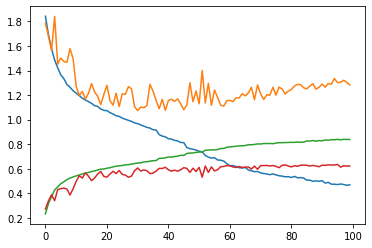

In [28]:
plt.plot(hist), best_acc


In [20]:
import pickle
pickle.dump(hist, open('baseline_vgg_3blocks_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7f27fc2fb438>,
 0.6575647812761215)

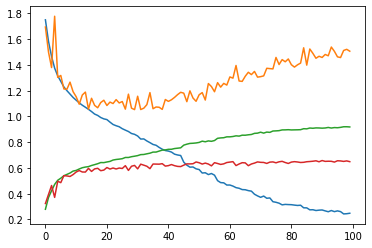

In [19]:
plt.plot(hist), best_acc


In [29]:
import pickle
pickle.dump(hist, open('baseline_vgg_4blocks_hist.hdf5', 'wb'))

In [11]:
# EVALUATE
test_model = torch.load('baseline_vgg_4blocks_model.pt')
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.472 | Avg. val_acc: 0.680


In [30]:
# EVALUATE
test_model = torch.load('baseline_vgg_3blocks_model.pt')
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.240 | Avg. val_acc: 0.636


## Squeeze and excitation idea

- Transform the curretn feature in 2 ways:
    - Global avg pool (to 1-d vector) -> Non-linear mapping (accross MxN)
    - Apply 1 filter 1x1conv (to 2-d matrix) -> Non-linear mapping (accross D)

In [175]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(SamplingDepth, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        # options
#         self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)
        
        return x

In [176]:
class SamplingSize(nn.Module):
    def __init__(self, size, depth):
        super(SamplingSize, self).__init__()
        
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, 1, kernel_size=1, padding=0, stride=1)
        self.fc = nn.Linear(size[0]*size[1], size[0]*size[1])
        
         # options
        self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, 1, self.size[0], self.size[1])
        
        return x
        

In [177]:
MAX_LOGSTD = 10
class SamplingLatentSpace(nn.Module):
    def __init__(self, in_size, mid_dim, dim):
        super(SamplingLatentSpace, self).__init__()
        
        
        self.mid_dim = mid_dim
        self.in_size = in_size

        self.relu = nn.ReLU()
        
        self.encode_conv = nn.Conv2d(in_size[0], mid_dim, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        fdim = mid_dim*in_size[1]*in_size[2]
        self.fc_mu = nn.Linear(fdim, dim)
        self.fc_logvar = nn.Linear(fdim, dim)
        
        self.decode_fc = nn.Linear(dim, fdim)
        self.decode_conv = nn.ConvTranspose2d(mid_dim, in_size[0], kernel_size=3, padding=1)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        
        return mu + std*eps
        
        
    def forward(self, x):
        
        # encode
        _x = self.encode_conv(x)
        _x = self.relu(_x)

#         _x = self.avgpool(x)
        _x = self.flatten(_x)
        
        x_mu = self.fc_mu(_x)
        x_logvar = self.fc_logvar(_x)
        
        # sampling
        z = self.reparameterize(x_mu, x_logvar)
        
        # decode
        x_decode = self.decode_fc(z)
        x_decode = self.relu(x_decode)
        x_decode = x_decode.view(-1, self.mid_dim, self.in_size[1], self.in_size[2])
        x_decode = self.decode_conv(x_decode)
        x_decode = self.relu(x_decode)
        
        return x, x_mu, x_logvar
        
        

In [131]:
32*20*20

12800

In [143]:
SamplingLatentSpace((128, 10, 10), 64, 64*10*10 //4)(torch.rand(12, 128, 10, 10))[0].size()

torch.Size([12, 64, 10, 10])
torch.Size([12, 6400])


torch.Size([12, 128, 10, 10])

In [192]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [193]:
class VGG_v1(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        super(VGG_v1, self).__init__()
        
        self.block1 = BasicBlock(in_channels, 32)
        self.block2 = BasicBlock(32, 64)
        self.block3 = BasicBlock(64, 128)
        self.block4 = BasicBlock(128, 256)
        
        self.alpha2 = Parameter(torch.rand(1,), requires_grad=True) 
        self.beta2 = Parameter(torch.rand(1,), requires_grad=True)
        self.alpha3 = Parameter(torch.rand(1,), requires_grad=True) 
        self.beta3 = Parameter(torch.rand(1,), requires_grad=True)
        self.alpha4 = Parameter(torch.rand(1,), requires_grad=True)
        self.beta4 = Parameter(torch.rand(1,), requires_grad=True)
        
#         torch.nn.init.zeros_(self.alpha2)
#         torch.nn.init.zeros_(self.beta2)
#         torch.nn.init.zeros_(self.alpha3)
#         torch.nn.init.zeros_(self.beta3)
#         torch.nn.init.zeros_(self.alpha4)
#         torch.nn.init.zeros_(self.beta4)
            
        self.ssize2 = SamplingSize((10,10), 64)
        self.sdepth2 = SamplingDepth(64, 64)
        self.bn_out2 = nn.BatchNorm2d(64)
        self.ssize3 = SamplingSize((5,5), 128)
        self.sdepth3 = SamplingDepth(128, 128)
        self.bn_out3 = nn.BatchNorm2d(128)
        self.ssize4 = SamplingSize((2,2), 256)
        self.sdepth4 = SamplingDepth(256, 256)
        self.bn_out4 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
        
        self.sz2 = SamplingLatentSpace((64, 10, 10), 32, 32*10*10 // 4)
        self.sz3 = SamplingLatentSpace((128, 5, 5), 64, 64*5*5 //4)
        self.sz4 = SamplingLatentSpace((256, 2, 2), 128, 128*2*2 //4)
#         self.ssize4 = SamplingSize((2,2), 512)
#         self.sdepth4 = SamplingDepth(512, 512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
                              nn.Linear(256, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
                              
                              nn.Linear(128, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
        
                              nn.Linear(128, out_channels, bias=True))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
        x2_d = self.sdepth2(x)
        x2_mn = self.ssize2(x)
        
        z2, mu2, logvar2 = self.sz2(x)
        x = z2 * ((self.alpha2 * x2_d[:,:,None,None]) + (self.beta2 * x2_mn))
        x = self.bn_out2(x)
        x = self.relu(x)
        
        x = self.block3(x)
        x = self.maxpool(x)
        x3_d = self.sdepth3(x)
        x3_mn = self.ssize3(x)
        z3, mu3, logvar3 = self.sz3(x)
        x = z3 * ((self.alpha3 * x3_d[:,:,None,None]) + (self.beta3 * x3_mn))
        x = self.bn_out3(x)
        x = self.relu(x)
        
        x = self.block4(x)
        x = self.maxpool(x)
        x4_d = self.sdepth4(x)
        x4_mn = self.ssize4(x)
        z4, mu4, logvar4 = self.sz4(x)
        x = z4 * ((self.alpha4 * x4_d[:,:,None,None]) + (self.beta4 * x4_mn))
        x = self.bn_out4(x)
        x = self.relu(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x, (mu2, logvar2), (mu3, logvar3), (mu4, logvar4)

In [194]:
device = torch.device('cuda')
model = VGG_v1().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [195]:
model_path = 'baseline_vgg_4blocks_kl_model.pt'

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, (mu2, logvar2), (mu3, logvar3), (mu4, logvar4) = model(inputs)
        kl_loss = (0.5 * torch.sum(-1 - logvar2 + mu2.pow(2) + logvar2.exp())) + (0.5 * torch.sum(-1 - logvar3 + mu3.pow(2) + logvar3.exp())) + (0.5 * torch.sum(-1 - logvar4 + mu4.pow(2) + logvar4.exp()))
        loss = criterion(outputs, labels) + kl_loss
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, (mu2, logvar2), (mu3, logvar3), (mu4, logvar4) = model(inputs)
        kl_loss = (0.5 * torch.sum(-1 - logvar2 + mu2.pow(2) + logvar2.exp())) + (0.5 * torch.sum(-1 - logvar3 + mu3.pow(2) + logvar3.exp()))+ (0.5 * torch.sum(-1 - logvar4 + mu4.pow(2) + logvar4.exp()))
        loss = criterion(outputs, labels) + kl_loss
        
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8227779865264893 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:11<00:00, 18.79it/s]

- Avg.loss: 60.636 | Avg.acc: 0.234



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.790 | Avg. val_acc: 0.254
* Update optimal model
Epoch:  2


Loss=1.7407317161560059 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:12<00:00, 18.56it/s]

- Avg.loss: 1.798 | Avg.acc: 0.250


- Avg. val_loss: 1.776 | Avg. val_acc: 0.263


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.7506752014160156 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:11<00:00, 19.07it/s]

- Avg.loss: 1.786 | Avg.acc: 0.256


- Avg. val_loss: 1.766 | Avg. val_acc: 0.276


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.6339918375015259 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:12<00:00, 18.73it/s]

- Avg.loss: 1.770 | Avg.acc: 0.263


- Avg. val_loss: 1.739 | Avg. val_acc: 0.295


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.7994643449783325 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:12<00:00, 18.59it/s]

- Avg.loss: 1.751 | Avg.acc: 0.279


- Avg. val_loss: 1.709 | Avg. val_acc: 0.312


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.7282450199127197 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:12<00:00, 18.57it/s]

- Avg.loss: 1.723 | Avg.acc: 0.304


- Avg. val_loss: 1.686 | Avg. val_acc: 0.325


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.8756015300750732 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:12<00:00, 18.56it/s]

- Avg.loss: 1.689 | Avg.acc: 0.322


- Avg. val_loss: 1.649 | Avg. val_acc: 0.342


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.6566344499588013 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:11<00:00, 18.76it/s]

- Avg.loss: 1.656 | Avg.acc: 0.341


- Avg. val_loss: 1.620 | Avg. val_acc: 0.359


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.4276541471481323 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:11<00:00, 18.87it/s]

- Avg.loss: 1.607 | Avg.acc: 0.364


- Avg. val_loss: 1.623 | Avg. val_acc: 0.388


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.6026084423065186 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:12<00:00, 18.59it/s]

- Avg.loss: 1.554 | Avg.acc: 0.387


- Avg. val_loss: 1.523 | Avg. val_acc: 0.397


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.214865803718567 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:12<00:00, 18.38it/s]

- Avg.loss: 1.507 | Avg.acc: 0.407


- Avg. val_loss: 1.459 | Avg. val_acc: 0.428


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.3007062673568726 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:12<00:00, 18.52it/s]

- Avg.loss: 1.466 | Avg.acc: 0.432


- Avg. val_loss: 1.443 | Avg. val_acc: 0.434


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.6850579977035522 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:12<00:00, 18.38it/s]

- Avg.loss: 1.432 | Avg.acc: 0.443


- Avg. val_loss: 1.414 | Avg. val_acc: 0.446


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.4950900077819824 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:12<00:00, 18.55it/s]

- Avg.loss: 1.400 | Avg.acc: 0.462


- Avg. val_loss: 1.397 | Avg. val_acc: 0.462


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.3079638481140137 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:11<00:00, 18.76it/s]

- Avg.loss: 1.365 | Avg.acc: 0.474



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.368 | Avg. val_acc: 0.458
Epoch:  16


Loss=1.3511064052581787 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:12<00:00, 18.54it/s]

- Avg.loss: 1.339 | Avg.acc: 0.492


- Avg. val_loss: 1.315 | Avg. val_acc: 0.491


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=1.2364721298217773 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:12<00:00, 18.53it/s]

- Avg.loss: 1.312 | Avg.acc: 0.502



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324 | Avg. val_acc: 0.490
Epoch:  18


Loss=1.2154810428619385 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:12<00:00, 18.57it/s]

- Avg.loss: 1.283 | Avg.acc: 0.515


- Avg. val_loss: 1.291 | Avg. val_acc: 0.511


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.1442288160324097 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:11<00:00, 18.93it/s]

- Avg.loss: 1.259 | Avg.acc: 0.525


- Avg. val_loss: 1.270 | Avg. val_acc: 0.519


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.9176629781723022 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:12<00:00, 18.59it/s]

- Avg.loss: 1.235 | Avg.acc: 0.536


- Avg. val_loss: 1.259 | Avg. val_acc: 0.523


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.2728967666625977 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:12<00:00, 18.70it/s]

- Avg.loss: 1.214 | Avg.acc: 0.540


- Avg. val_loss: 1.244 | Avg. val_acc: 0.525


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.2891899347305298 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:12<00:00, 18.64it/s]

- Avg.loss: 1.086 | Avg.acc: 0.599


- Avg. val_loss: 1.129 | Avg. val_acc: 0.568


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.9791768789291382 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:12<00:00, 18.38it/s]

- Avg.loss: 1.075 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.563
Epoch:  30


Loss=1.1165895462036133 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:11<00:00, 18.78it/s]

- Avg.loss: 1.059 | Avg.acc: 0.609


- Avg. val_loss: 1.120 | Avg. val_acc: 0.571


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=1.3342169523239136 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:12<00:00, 18.73it/s]

- Avg.loss: 1.048 | Avg.acc: 0.614


- Avg. val_loss: 1.136 | Avg. val_acc: 0.586


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  32


Loss=1.2232978343963623 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:12<00:00, 18.55it/s]

- Avg.loss: 1.034 | Avg.acc: 0.622


- Avg. val_loss: 1.093 | Avg. val_acc: 0.593


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.2842098474502563 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:12<00:00, 18.64it/s]

- Avg.loss: 1.020 | Avg.acc: 0.627



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.100 | Avg. val_acc: 0.587
Epoch:  34


Loss=0.7191396951675415 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:12<00:00, 18.65it/s]

- Avg.loss: 1.012 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105 | Avg. val_acc: 0.581
Epoch:  35


Loss=1.044286847114563 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:12<00:00, 18.50it/s]

- Avg.loss: 0.993 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074 | Avg. val_acc: 0.593
Epoch:  36


Loss=0.9693059921264648 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:12<00:00, 18.30it/s]

- Avg.loss: 0.990 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130 | Avg. val_acc: 0.588
Epoch:  37


Loss=1.0845400094985962 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:11<00:00, 18.78it/s]

- Avg.loss: 0.968 | Avg.acc: 0.647


- Avg. val_loss: 1.063 | Avg. val_acc: 0.610


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=1.0260190963745117 Batch_id=8 Accuracy=0.65625:   4%|▎         | 8/225 [00:01<00:58,  3.70it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.5480976104736328 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:12<00:00, 18.44it/s]

- Avg.loss: 0.711 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.627
Epoch:  62


Loss=0.48791277408599854 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:12<00:00, 18.61it/s]

- Avg.loss: 0.682 | Avg.acc: 0.760


- Avg. val_loss: 1.108 | Avg. val_acc: 0.637


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  63


Loss=1.0039055347442627 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:12<00:00, 18.49it/s]

- Avg.loss: 0.686 | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.112 | Avg. val_acc: 0.631
Epoch:  64


Loss=0.9465203285217285 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:11<00:00, 18.89it/s]

- Avg.loss: 0.667 | Avg.acc: 0.764



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153 | Avg. val_acc: 0.624
Epoch:  65


Loss=0.9269157648086548 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:12<00:00, 18.75it/s]

- Avg.loss: 0.667 | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.634
Epoch:  66


Loss=1.1604969501495361 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:12<00:00, 18.67it/s]

- Avg.loss: 0.655 | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.621
Epoch:  67


Loss=0.8044629693031311 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:11<00:00, 19.04it/s]

- Avg.loss: 0.653 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.625
Epoch:  68


Loss=0.7645473480224609 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:12<00:00, 18.66it/s]

- Avg.loss: 0.639 | Avg.acc: 0.776



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.135 | Avg. val_acc: 0.622
Epoch    68: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  69


Loss=0.8864229321479797 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:12<00:00, 18.36it/s]

- Avg.loss: 0.592 | Avg.acc: 0.793


- Avg. val_loss: 1.159 | Avg. val_acc: 0.645


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  70


Loss=0.5540096759796143 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:12<00:00, 18.70it/s]

- Avg.loss: 0.577 | Avg.acc: 0.798



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.639
Epoch:  71


Loss=0.828916072845459 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:12<00:00, 18.68it/s]

- Avg.loss: 0.567 | Avg.acc: 0.802


- Avg. val_loss: 1.164 | Avg. val_acc: 0.646


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  72


Loss=0.8013886213302612 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:12<00:00, 18.63it/s]

- Avg.loss: 0.557 | Avg.acc: 0.807



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207 | Avg. val_acc: 0.626
Epoch:  73


Loss=0.6845830678939819 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:12<00:00, 18.62it/s]

- Avg.loss: 0.546 | Avg.acc: 0.810



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.183 | Avg. val_acc: 0.640
Epoch:  74


Loss=0.6075471639633179 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:12<00:00, 18.36it/s]

- Avg.loss: 0.546 | Avg.acc: 0.811



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.202 | Avg. val_acc: 0.645
Epoch:  75


Loss=0.5200480222702026 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:12<00:00, 18.41it/s]

- Avg.loss: 0.456 | Avg.acc: 0.843



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.642
Epoch:  82


Loss=0.38916563987731934 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:12<00:00, 18.52it/s]

- Avg.loss: 0.456 | Avg.acc: 0.847



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.314 | Avg. val_acc: 0.649
Epoch:  83


Loss=0.39372894167900085 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:12<00:00, 18.68it/s]

- Avg.loss: 0.437 | Avg.acc: 0.852



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.304 | Avg. val_acc: 0.641
Epoch:  84


Loss=0.462513267993927 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:12<00:00, 18.58it/s]

- Avg.loss: 0.438 | Avg.acc: 0.850



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.646
Epoch:  85


Loss=0.3485235273838043 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:12<00:00, 18.66it/s]

- Avg.loss: 0.430 | Avg.acc: 0.852



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.403 | Avg. val_acc: 0.636
Epoch    85: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  86


Loss=0.644244372844696 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:12<00:00, 18.41it/s]

- Avg.loss: 0.406 | Avg.acc: 0.860



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.650
Epoch:  87


Loss=0.7539705038070679 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:12<00:00, 18.36it/s]

- Avg.loss: 0.391 | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.404 | Avg. val_acc: 0.640
Epoch:  88


Loss=0.2939964234828949 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:11<00:00, 18.84it/s]

- Avg.loss: 0.390 | Avg.acc: 0.868



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.352 | Avg. val_acc: 0.650
Epoch:  89


Loss=0.5953191518783569 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:12<00:00, 18.44it/s]

- Avg.loss: 0.384 | Avg.acc: 0.870



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.382 | Avg. val_acc: 0.646
Epoch:  90


Loss=0.8358082175254822 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:12<00:00, 18.31it/s]

- Avg.loss: 0.382 | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.434 | Avg. val_acc: 0.641
Epoch:  91


Loss=0.43565014004707336 Batch_id=10 Accuracy=0.828125:   5%|▍         | 11/225 [00:01<00:32,  6.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



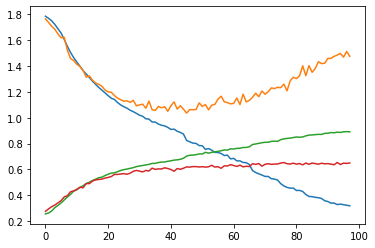

In [197]:
#4block kl
plt.plot(hist[2:])

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f21da11cd30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


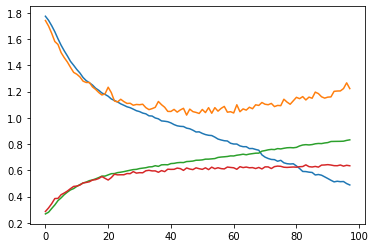

In [153]:
plt.plot(hist[2:])

In [200]:
# EVALUATE
test_model = torch.load('baseline_vgg_4blocks_kl_model.pt')
# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, (mu2, logvar2), (mu3, logvar3), (mu4, logvar4) = model(inputs)
    kl_loss = (0.5 * torch.sum(-1 - logvar2 + mu2.pow(2) + logvar2.exp())) + (0.5 * torch.sum(-1 - logvar3 + mu3.pow(2) + logvar3.exp()))+ (0.5 * torch.sum(-1 - logvar4 + mu4.pow(2) + logvar4.exp()))
    loss = criterion(outputs, labels) + kl_loss


    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.406 | Avg. val_acc: 0.658


In [155]:
# EVALUATE
test_model = torch.load('baseline_vgg_3blocks_kl_model.pt')
# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, (mu2, logvar2), (mu3, logvar3) = model(inputs)
    kl_loss = (0.5 * torch.sum(-1 - logvar2 + mu2.pow(2) + logvar2.exp())) + (0.5 * torch.sum(-1 - logvar3 + mu3.pow(2) + logvar3.exp()))
    loss = criterion(outputs, labels) + kl_loss


    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.142 | Avg. val_acc: 0.649


In [160]:
test_model.beta2

Parameter containing:
tensor([0.0881], device='cuda:0', requires_grad=True)

### VGG_v3

In [46]:
class SamplingDepth(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0, heads=4):
        super(SamplingDepth, self).__init__()
        self.heads=heads
        self.out_channels = out_channels
        
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout, inplace=False)
        
        # options
#         self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()
        
    def forward(self, x):
        x = self.global_pool(x)
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.activation(x)
        x = x.reshape(-1, self.heads, self.out_channels // self.heads)
        return x

In [47]:
class SamplingSize(nn.Module):
    def __init__(self, size, depth, heads):
        super(SamplingSize, self).__init__()
        
        self.heads = heads
        self.size = size
        self.conv1x1 = nn.Conv2d(depth, heads, kernel_size=1, padding=0, stride=1)
        self.fc = nn.Linear(heads*size[0]*size[1], heads*size[0]*size[1])
        
         # options
        self.activation = nn.ReLU(inplace=True)
        self.activation = nn.Sigmoid()
#         self.activation = nn.Softmax()

    def forward(self, x):
        x = self.conv1x1(x)
        x = nn.Flatten()(x)
        x = self.fc(x)
        x = self.activation(x)
        
        x = x.reshape(-1, self.heads, self.size[0], self.size[1])
        
        return x
        

In [48]:
class VGG_v3(nn.Module):
    def __init__(self, in_channels=1, out_channels=7, heads=4):
        super(VGG_v3, self).__init__()
        
        self.block1 = BasicBlock(in_channels, 64)
        self.block2 = BasicBlock(64, 128)
        self.block3 = BasicBlock(128, 256)
        self.block4 = BasicBlock(256, 512)
        
        self.alpha3 = Parameter(torch.rand(heads,), requires_grad=True) 
        self.beta3 = Parameter(torch.rand(heads,), requires_grad=True)
        self.alpha4 = Parameter(torch.rand(heads,), requires_grad=True)
        self.beta4 = Parameter(torch.rand(heads,), requires_grad=True)
        
        torch.nn.init.zeros_(self.alpha3)
        torch.nn.init.zeros_(self.beta3)
        torch.nn.init.zeros_(self.alpha4)
        torch.nn.init.zeros_(self.beta4)
        
        self.dim_3 = 256 // heads
        self.dim_4 = 512 // heads
        
        self.conv3_1x1 = nn.Conv2d(256, self.dim_3, kernel_size=1, padding=0, stride=1)
        self.conv4_1x1 = nn.Conv2d(512, self.dim_4, kernel_size=1, padding=0, stride=1)
            
        self.ssize3 = SamplingSize((5,5), 256, heads=4)
        self.sdepth3 = SamplingDepth(256, self.dim_3, dropout=0.0, heads=heads)
        
        self.ssize4 = SamplingSize((2,2), 512, heads=4)
        self.sdepth4 = SamplingDepth(512, self.dim_4, dropout=0.0, heads=heads)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
                              nn.Linear(2048, 4096, bias=True),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
                              
                              nn.Linear(4096, 4096, bias=True),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5, inplace=False),
        
                              nn.Linear(4096, out_channels, bias=True))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
        
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.conv3_1x1(x)
        
        x3_d = self.sdepth3(x)
        x3_mn = self.ssize3(x)
        out_x3_d = torch.x[:,None,:,:,:] * self.alpha3[None,:,None,None,None] * x3_d[:,:,:,None,None]
        out_x3_d = out_x3_d.reshape(x.size())
        
        out_x3_mn = x[:,None,:,:,:] * self.beta3[None,:,None,None,None] * x3_mn[:,:,None,:,:]
        out_x3_mn = out_x3_mn.reshape(x.size())
        
        x = out_x3_d + out_x3_mn
        
        x = self.block4(x)
        x = self.maxpool(x)
        x4_d = self.sdepth4(x)
        x4_mn = self.ssize4(x)
        x = x * self.alpha4 * x4_d[:,:,None,None] + x * self.beta4 * x4_mn
        
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

In [106]:
model(torch.rand(12, 1, 40, 40).to(device))

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [63]:
device = torch.device('cuda')
model = VGG_v1().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [64]:
model_path = 'baseline_vgg_3blocks_v1_model.pt'

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5949732065200806 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:08<00:00, 27.63it/s]

- Avg.loss: 1.768 | Avg.acc: 0.277



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.691 | Avg. val_acc: 0.341
* Update optimal model
Epoch:  2


Loss=1.3561224937438965 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:07<00:00, 28.25it/s]

- Avg.loss: 1.509 | Avg.acc: 0.412



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.445 | Avg. val_acc: 0.441
* Update optimal model
Epoch:  3


Loss=1.8330587148666382 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:08<00:00, 27.80it/s]

- Avg.loss: 1.339 | Avg.acc: 0.493



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.268 | Avg. val_acc: 0.521
* Update optimal model
Epoch:  4


Loss=1.2029004096984863 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:08<00:00, 27.73it/s]

- Avg.loss: 1.258 | Avg.acc: 0.526



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.242 | Avg. val_acc: 0.519
Epoch:  5


Loss=1.2495346069335938 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:07<00:00, 28.33it/s]

- Avg.loss: 1.207 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188 | Avg. val_acc: 0.546
* Update optimal model
Epoch:  6


Loss=1.26300847530365 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:08<00:00, 27.90it/s]

- Avg.loss: 1.167 | Avg.acc: 0.565



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171 | Avg. val_acc: 0.545
Epoch:  7


Loss=1.230943202972412 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:07<00:00, 28.13it/s]

- Avg.loss: 1.128 | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  8


Loss=1.1577889919281006 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:08<00:00, 27.19it/s]

- Avg.loss: 1.113 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.563
Epoch:  9


Loss=0.9698560833930969 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:08<00:00, 28.10it/s]

- Avg.loss: 1.082 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.551
Epoch:  10


Loss=1.0033323764801025 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 28.08it/s]

- Avg.loss: 1.071 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.583
* Update optimal model
Epoch:  11


Loss=1.0156091451644897 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 28.02it/s]

- Avg.loss: 1.045 | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155 | Avg. val_acc: 0.560
Epoch:  12


Loss=0.8331350088119507 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:07<00:00, 28.45it/s]

- Avg.loss: 1.034 | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.062 | Avg. val_acc: 0.595
* Update optimal model
Epoch:  13


Loss=1.1025867462158203 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 27.57it/s]

- Avg.loss: 1.018 | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083 | Avg. val_acc: 0.598
* Update optimal model
Epoch:  14


Loss=1.0540496110916138 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 28.11it/s]

- Avg.loss: 1.004 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.581
Epoch:  15


Loss=0.8669224381446838 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:07<00:00, 28.15it/s]

- Avg.loss: 0.991 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.041 | Avg. val_acc: 0.607
* Update optimal model
Epoch:  16


Loss=0.8531583547592163 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 27.82it/s]

- Avg.loss: 0.976 | Avg.acc: 0.645



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.048 | Avg. val_acc: 0.604
Epoch:  17


Loss=0.9214972257614136 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 28.00it/s]

- Avg.loss: 0.961 | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067 | Avg. val_acc: 0.601
Epoch:  18


Loss=0.9071841835975647 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 27.78it/s]

- Avg.loss: 0.953 | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.597
Epoch:  19


Loss=0.9664970636367798 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:07<00:00, 28.41it/s]

- Avg.loss: 0.940 | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.598
Epoch:  20


Loss=0.9789401888847351 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 27.90it/s]


- Avg.loss: 0.931 | Avg.acc: 0.663


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.598
Epoch:  21


Loss=0.8390480875968933 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 27.99it/s]

- Avg.loss: 0.923 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  22


Loss=0.8566765785217285 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 27.50it/s]

- Avg.loss: 0.905 | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070 | Avg. val_acc: 0.610
Epoch:  23


Loss=0.8697710037231445 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 27.92it/s]

- Avg.loss: 0.893 | Avg.acc: 0.676



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.614
Epoch:  24


Loss=0.8682211637496948 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:08<00:00, 27.71it/s]

- Avg.loss: 0.884 | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042 | Avg. val_acc: 0.615
Epoch:  25


Loss=0.8949112892150879 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 28.12it/s]

- Avg.loss: 0.881 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031 | Avg. val_acc: 0.626
* Update optimal model
Epoch:  26


Loss=1.0764914751052856 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:08<00:00, 27.84it/s]

- Avg.loss: 0.864 | Avg.acc: 0.688



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044 | Avg. val_acc: 0.615
Epoch:  27


Loss=0.7621972560882568 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 27.81it/s]

- Avg.loss: 0.856 | Avg.acc: 0.693



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.622
Epoch:  28


Loss=1.3259649276733398 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:08<00:00, 27.94it/s]

- Avg.loss: 0.848 | Avg.acc: 0.696



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.623
Epoch:  29


Loss=0.6942237615585327 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 28.01it/s]

- Avg.loss: 0.842 | Avg.acc: 0.697



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.614
Epoch:  30


Loss=0.713660717010498 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 27.80it/s]

- Avg.loss: 0.827 | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088 | Avg. val_acc: 0.607
Epoch:  31


Loss=1.288770318031311 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 27.68it/s]

- Avg.loss: 0.818 | Avg.acc: 0.707



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.624
Epoch    31: reducing learning rate of group 0 to 7.5000e-04.
Epoch:  32


Loss=0.8778702020645142 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:08<00:00, 27.90it/s]

- Avg.loss: 0.787 | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.055 | Avg. val_acc: 0.627
* Update optimal model
Epoch:  33


Loss=1.2266645431518555 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:08<00:00, 27.82it/s]

- Avg.loss: 0.774 | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.049 | Avg. val_acc: 0.628
* Update optimal model
Epoch:  34


Loss=0.7526988983154297 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 27.94it/s]

- Avg.loss: 0.770 | Avg.acc: 0.725



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.620
Epoch:  35


Loss=0.8474567532539368 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 27.77it/s]

- Avg.loss: 0.755 | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093 | Avg. val_acc: 0.621
Epoch:  36


Loss=0.8171097040176392 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 27.64it/s]

- Avg.loss: 0.748 | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073 | Avg. val_acc: 0.630
* Update optimal model
Epoch:  37


Loss=0.6560651063919067 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.70it/s]

- Avg.loss: 0.738 | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069 | Avg. val_acc: 0.632
* Update optimal model
Epoch:  38


Loss=0.7113894820213318 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 27.88it/s]

- Avg.loss: 0.730 | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058 | Avg. val_acc: 0.632
* Update optimal model
Epoch:  39


Loss=0.6148494482040405 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 28.00it/s]

- Avg.loss: 0.721 | Avg.acc: 0.742



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.053 | Avg. val_acc: 0.639
* Update optimal model
Epoch:  40


Loss=0.6240665316581726 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 28.06it/s]

- Avg.loss: 0.713 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.110 | Avg. val_acc: 0.627
Epoch:  41


Loss=0.8273338079452515 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 27.67it/s]

- Avg.loss: 0.710 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.624
Epoch:  42


Loss=0.5162248015403748 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.92it/s]

- Avg.loss: 0.700 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084 | Avg. val_acc: 0.630
Epoch:  43


Loss=0.7630712389945984 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.42it/s]

- Avg.loss: 0.693 | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.627
Epoch:  44


Loss=0.7961161732673645 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 28.05it/s]

- Avg.loss: 0.686 | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095 | Avg. val_acc: 0.629
Epoch:  45


Loss=0.7174444198608398 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 27.80it/s]

- Avg.loss: 0.683 | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103 | Avg. val_acc: 0.627
Epoch    45: reducing learning rate of group 0 to 5.6250e-04.
Epoch:  46


Loss=0.5504674911499023 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 27.76it/s]

- Avg.loss: 0.657 | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.625
Epoch:  47


Loss=1.0715879201889038 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 28.02it/s]

- Avg.loss: 0.648 | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.106 | Avg. val_acc: 0.630
Epoch:  48


Loss=0.478801429271698 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:07<00:00, 28.36it/s]

- Avg.loss: 0.635 | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.109 | Avg. val_acc: 0.635
Epoch:  49


Loss=0.6891446113586426 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:07<00:00, 28.16it/s]

- Avg.loss: 0.631 | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.626
Epoch:  50


Loss=0.5360175967216492 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.49it/s]

- Avg.loss: 0.624 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138 | Avg. val_acc: 0.632
Epoch:  51


Loss=0.6770251393318176 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 28.06it/s]

- Avg.loss: 0.622 | Avg.acc: 0.783



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.625
Epoch    51: reducing learning rate of group 0 to 4.2188e-04.
Epoch:  52


Loss=0.6528595685958862 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:07<00:00, 28.32it/s]

- Avg.loss: 0.596 | Avg.acc: 0.793



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137 | Avg. val_acc: 0.632
Epoch:  53


Loss=0.661006510257721 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:08<00:00, 27.90it/s]

- Avg.loss: 0.589 | Avg.acc: 0.795



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.624
Epoch:  54


Loss=0.5025643706321716 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.83it/s]

- Avg.loss: 0.578 | Avg.acc: 0.799



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.634
Epoch:  55


Loss=0.4005260169506073 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 28.05it/s]

- Avg.loss: 0.569 | Avg.acc: 0.800



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.167 | Avg. val_acc: 0.627
Epoch:  56


Loss=0.7596414685249329 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:07<00:00, 28.53it/s]

- Avg.loss: 0.561 | Avg.acc: 0.803



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178 | Avg. val_acc: 0.633
Epoch:  57


Loss=0.8228681087493896 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:07<00:00, 28.18it/s]

- Avg.loss: 0.563 | Avg.acc: 0.802



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193 | Avg. val_acc: 0.626
Epoch    57: reducing learning rate of group 0 to 3.1641e-04.
Epoch:  58


Loss=0.5484351515769958 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 27.67it/s]

- Avg.loss: 0.542 | Avg.acc: 0.811



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203 | Avg. val_acc: 0.634
Epoch:  59


Loss=0.397613525390625 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 27.79it/s]

- Avg.loss: 0.532 | Avg.acc: 0.816



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.629
Epoch:  60


Loss=0.7578104734420776 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 28.08it/s]

- Avg.loss: 0.527 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.234 | Avg. val_acc: 0.629
Epoch:  61


Loss=0.8195071220397949 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 28.07it/s]

- Avg.loss: 0.529 | Avg.acc: 0.814



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.234 | Avg. val_acc: 0.640
* Update optimal model
Epoch:  62


Loss=0.5007851123809814 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 27.73it/s]

- Avg.loss: 0.523 | Avg.acc: 0.817



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.210 | Avg. val_acc: 0.631
Epoch:  63


Loss=0.6330521106719971 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.75it/s]

- Avg.loss: 0.521 | Avg.acc: 0.818



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.211 | Avg. val_acc: 0.630
Epoch:  64


Loss=0.44552427530288696 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 27.41it/s]

- Avg.loss: 0.510 | Avg.acc: 0.825



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.237 | Avg. val_acc: 0.634
Epoch:  65


Loss=0.2313634753227234 Batch_id=224 Accuracy=0.972972972972973: 100%|██████████| 225/225 [00:08<00:00, 27.61it/s]

- Avg.loss: 0.504 | Avg.acc: 0.824



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.219 | Avg. val_acc: 0.637
Epoch:  66


Loss=0.3756486475467682 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:08<00:00, 27.83it/s]

- Avg.loss: 0.502 | Avg.acc: 0.827



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.251 | Avg. val_acc: 0.629
Epoch:  67


Loss=0.4802304208278656 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 27.54it/s]

- Avg.loss: 0.504 | Avg.acc: 0.827



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.236 | Avg. val_acc: 0.630
Epoch    67: reducing learning rate of group 0 to 2.3730e-04.
Epoch:  68


Loss=0.39723706245422363 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 27.85it/s]

- Avg.loss: 0.488 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.260 | Avg. val_acc: 0.630
Epoch:  69


Loss=0.8275901675224304 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:08<00:00, 27.59it/s]

- Avg.loss: 0.483 | Avg.acc: 0.831



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.257 | Avg. val_acc: 0.632
Epoch:  70


Loss=0.7375020384788513 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 27.90it/s]

- Avg.loss: 0.476 | Avg.acc: 0.835



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.293 | Avg. val_acc: 0.631
Epoch:  71


Loss=0.2941493093967438 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 27.98it/s]

- Avg.loss: 0.480 | Avg.acc: 0.834



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.262 | Avg. val_acc: 0.627
Epoch:  72


Loss=0.47201356291770935 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 27.57it/s]

- Avg.loss: 0.476 | Avg.acc: 0.837



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289 | Avg. val_acc: 0.627
Epoch:  73


Loss=0.5170596241950989 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:07<00:00, 28.19it/s]

- Avg.loss: 0.468 | Avg.acc: 0.839



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.274 | Avg. val_acc: 0.627
Epoch    73: reducing learning rate of group 0 to 1.7798e-04.
Epoch:  74


Loss=0.6822053790092468 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 27.75it/s]

- Avg.loss: 0.456 | Avg.acc: 0.842



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.283 | Avg. val_acc: 0.636
Epoch:  75


Loss=0.4362785816192627 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 27.84it/s]

- Avg.loss: 0.451 | Avg.acc: 0.845



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.299 | Avg. val_acc: 0.630
Epoch:  76


Loss=0.566236674785614 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.59it/s]

- Avg.loss: 0.459 | Avg.acc: 0.843



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.299 | Avg. val_acc: 0.629
Epoch:  77


Loss=0.5538292527198792 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:07<00:00, 28.19it/s]

- Avg.loss: 0.459 | Avg.acc: 0.845



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.303 | Avg. val_acc: 0.635
Epoch:  78


Loss=0.5652074813842773 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:07<00:00, 28.62it/s]

- Avg.loss: 0.442 | Avg.acc: 0.847



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.327 | Avg. val_acc: 0.634
Epoch:  79


Loss=0.3481936752796173 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 27.57it/s]

- Avg.loss: 0.439 | Avg.acc: 0.848



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312 | Avg. val_acc: 0.632
Epoch    79: reducing learning rate of group 0 to 1.3348e-04.
Epoch:  80


Loss=0.4038141965866089 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:07<00:00, 28.87it/s]

- Avg.loss: 0.447 | Avg.acc: 0.845



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.305 | Avg. val_acc: 0.632
Epoch:  81


Loss=0.5703796744346619 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 27.76it/s]

- Avg.loss: 0.437 | Avg.acc: 0.850



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.307 | Avg. val_acc: 0.636
Epoch:  82


Loss=0.5328739285469055 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 27.96it/s]

- Avg.loss: 0.431 | Avg.acc: 0.851



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.314 | Avg. val_acc: 0.632
Epoch:  83


Loss=0.6749944090843201 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 27.76it/s]

- Avg.loss: 0.429 | Avg.acc: 0.853



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.317 | Avg. val_acc: 0.634
Epoch:  84


Loss=0.5399744510650635 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 27.92it/s]

- Avg.loss: 0.429 | Avg.acc: 0.854



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.319 | Avg. val_acc: 0.634
Epoch:  85


Loss=0.5922568440437317 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:07<00:00, 28.14it/s]

- Avg.loss: 0.429 | Avg.acc: 0.852



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.331 | Avg. val_acc: 0.636
Epoch    85: reducing learning rate of group 0 to 1.0011e-04.
Epoch:  86


Loss=0.691729724407196 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 27.84it/s]

- Avg.loss: 0.412 | Avg.acc: 0.858



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.354 | Avg. val_acc: 0.634
Epoch:  87


Loss=0.5066234469413757 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [00:08<00:00, 27.43it/s]

- Avg.loss: 0.420 | Avg.acc: 0.855



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.327 | Avg. val_acc: 0.638
Epoch:  88


Loss=0.35707351565361023 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 27.97it/s]

- Avg.loss: 0.413 | Avg.acc: 0.858



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.338 | Avg. val_acc: 0.637
Epoch:  89


Loss=0.45437756180763245 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:07<00:00, 28.19it/s]

- Avg.loss: 0.412 | Avg.acc: 0.857



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324 | Avg. val_acc: 0.634
Epoch:  90


Loss=0.29360532760620117 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 27.61it/s]

- Avg.loss: 0.416 | Avg.acc: 0.860



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.334 | Avg. val_acc: 0.633
Epoch:  91


Loss=0.34666717052459717 Batch_id=224 Accuracy=0.918918918918919: 100%|██████████| 225/225 [00:07<00:00, 28.33it/s]

- Avg.loss: 0.411 | Avg.acc: 0.859



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.340 | Avg. val_acc: 0.634
Epoch    91: reducing learning rate of group 0 to 7.5085e-05.
Epoch:  92


Loss=0.3094465136528015 Batch_id=224 Accuracy=0.8648648648648649: 100%|██████████| 225/225 [00:08<00:00, 27.16it/s]

- Avg.loss: 0.403 | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.638
Epoch:  93


Loss=0.33733639121055603 Batch_id=224 Accuracy=0.8918918918918919: 100%|██████████| 225/225 [00:08<00:00, 27.96it/s]

- Avg.loss: 0.410 | Avg.acc: 0.861



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.341 | Avg. val_acc: 0.638
Epoch:  94


Loss=0.46071553230285645 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 27.85it/s]

- Avg.loss: 0.410 | Avg.acc: 0.861



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.356 | Avg. val_acc: 0.629
Epoch:  95


Loss=0.2611526846885681 Batch_id=224 Accuracy=0.9459459459459459: 100%|██████████| 225/225 [00:08<00:00, 27.41it/s]

- Avg.loss: 0.399 | Avg.acc: 0.865



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.355 | Avg. val_acc: 0.633
Epoch:  96


Loss=0.5159837603569031 Batch_id=224 Accuracy=0.8108108108108109: 100%|██████████| 225/225 [00:08<00:00, 27.88it/s]

- Avg.loss: 0.412 | Avg.acc: 0.860



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.640
Epoch:  97


Loss=0.5219773054122925 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [00:08<00:00, 28.04it/s]

- Avg.loss: 0.395 | Avg.acc: 0.867



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.339 | Avg. val_acc: 0.638
Epoch    97: reducing learning rate of group 0 to 5.6314e-05.
Epoch:  98


Loss=0.48842063546180725 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:07<00:00, 28.36it/s]

- Avg.loss: 0.394 | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.355 | Avg. val_acc: 0.631
Epoch:  99


Loss=0.5244364142417908 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [00:08<00:00, 27.71it/s]

- Avg.loss: 0.397 | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.353 | Avg. val_acc: 0.634
Epoch:  100


Loss=0.452157199382782 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [00:08<00:00, 27.43it/s]

- Avg.loss: 0.395 | Avg.acc: 0.865


- Avg. val_loss: 1.366 | Avg. val_acc: 0.636
Finished Training


([<matplotlib.lines.Line2D at 0x7f21d9cd8d68>,
 0.6402897743103929)

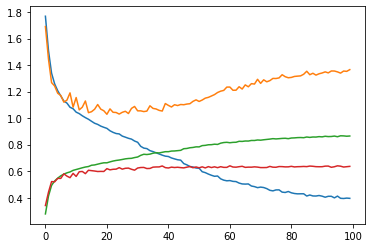

In [65]:
# v1 3 blocks
plt.plot(hist), best_acc


In [66]:
import pickle
pickle.dump(hist, open('baseline_vgg_3blocks_v1_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7fdea67a7438>,
 0.6756756756756757)

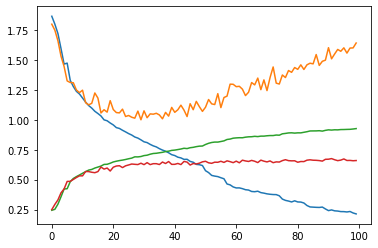

In [27]:
# v1
plt.plot(hist), best_acc


In [37]:
import pickle
pickle.dump(hist, open('baseline_vgg_4blocks_v1_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7f8dbd75db38>,
 0.6692672053496795)

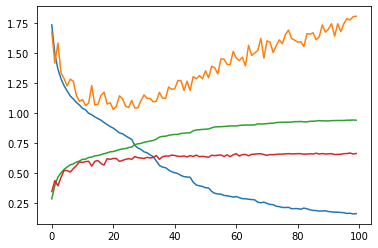

In [14]:
# v2
plt.plot(hist), best_acc

In [15]:
import pickle
pickle.dump(hist, open('baseline_vgg_4blocks_v2_hist.hdf5', 'wb'))

In [67]:
# EVALUATE
test_model = torch.load('baseline_vgg_3blocks_v1_model.pt')
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.142 | Avg. val_acc: 0.647


In [29]:
# EVALUATE
test_model = torch.load('baseline_vgg_4blocks_v1_model.pt')
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.471 | Avg. val_acc: 0.663


In [24]:
# EVALUATE
test_model = torch.load('baseline_vgg_4blocks_v2_model.pt')
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.655 | Avg. val_acc: 0.676


### Visualization

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

def attention(model, img, lb=None, visual_heatmap=True, ext_output=False, grayscale=True, return_heatmap=False):
    model.eval()
    if ext_output:
        output, _ = model(img.unsqueeze(0))
    else:
        output = model(img.unsqueeze(0))
    prob = nn.Softmax()(output.detach())
    prob = float(prob.max(1)[0][0])
    
    
    pred_lb = int(output.argmax(1)[0])
    
    lb = pred_lb if lb is None else lb
    output[:,lb].backward()

    # get gradient
    grads = gradients['last_conv'][0]
    
    # !!! 2 options
#     pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # get activation
    features = activation['last_conv']

    # weight the channels by corresponding gradients
    print('features: ', features.size())
    print('pooled grads: ', pooled_grads.size())
    
    for i in range(features.size(1)):
        features[:, i, :, :] *= pooled_grads[0,i,:,:]
   
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
 
    # 1 channel
    if grayscale:
        img = img.numpy()[0]
        img = np.stack((img,)*3, axis=-1)
        
    # 3 channels
    else:
        img = img.numpy().transpose((1,2,0))
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    heatmap = heatmap[:,:,::-1] #bgr -> rgb
    
    superimposed_img = heatmap * 0.008 + img # here 0.4 is the heat map intensity factor
        
    superimposed_img /= np.max(superimposed_img)
    
    if not return_heatmap:    
        return superimposed_img, pred_lb, int(lb), prob
    
    else:
        return superimposed_img, pred_lb, int(lb), prob, heatmap


# activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook


In [22]:
test_model = torch.load('baseline_vgg_4blocks_v2_model.pt')
test_model = test_model.cpu()
test_model.eval()

VGG_v1(
  (block1): BasicBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [19]:
activation = {}
gradients = {}


# print(model)

test_model.block4.register_forward_hook(get_activation('last_conv'))
test_model.block4.register_backward_hook(get_gradient('last_conv'))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


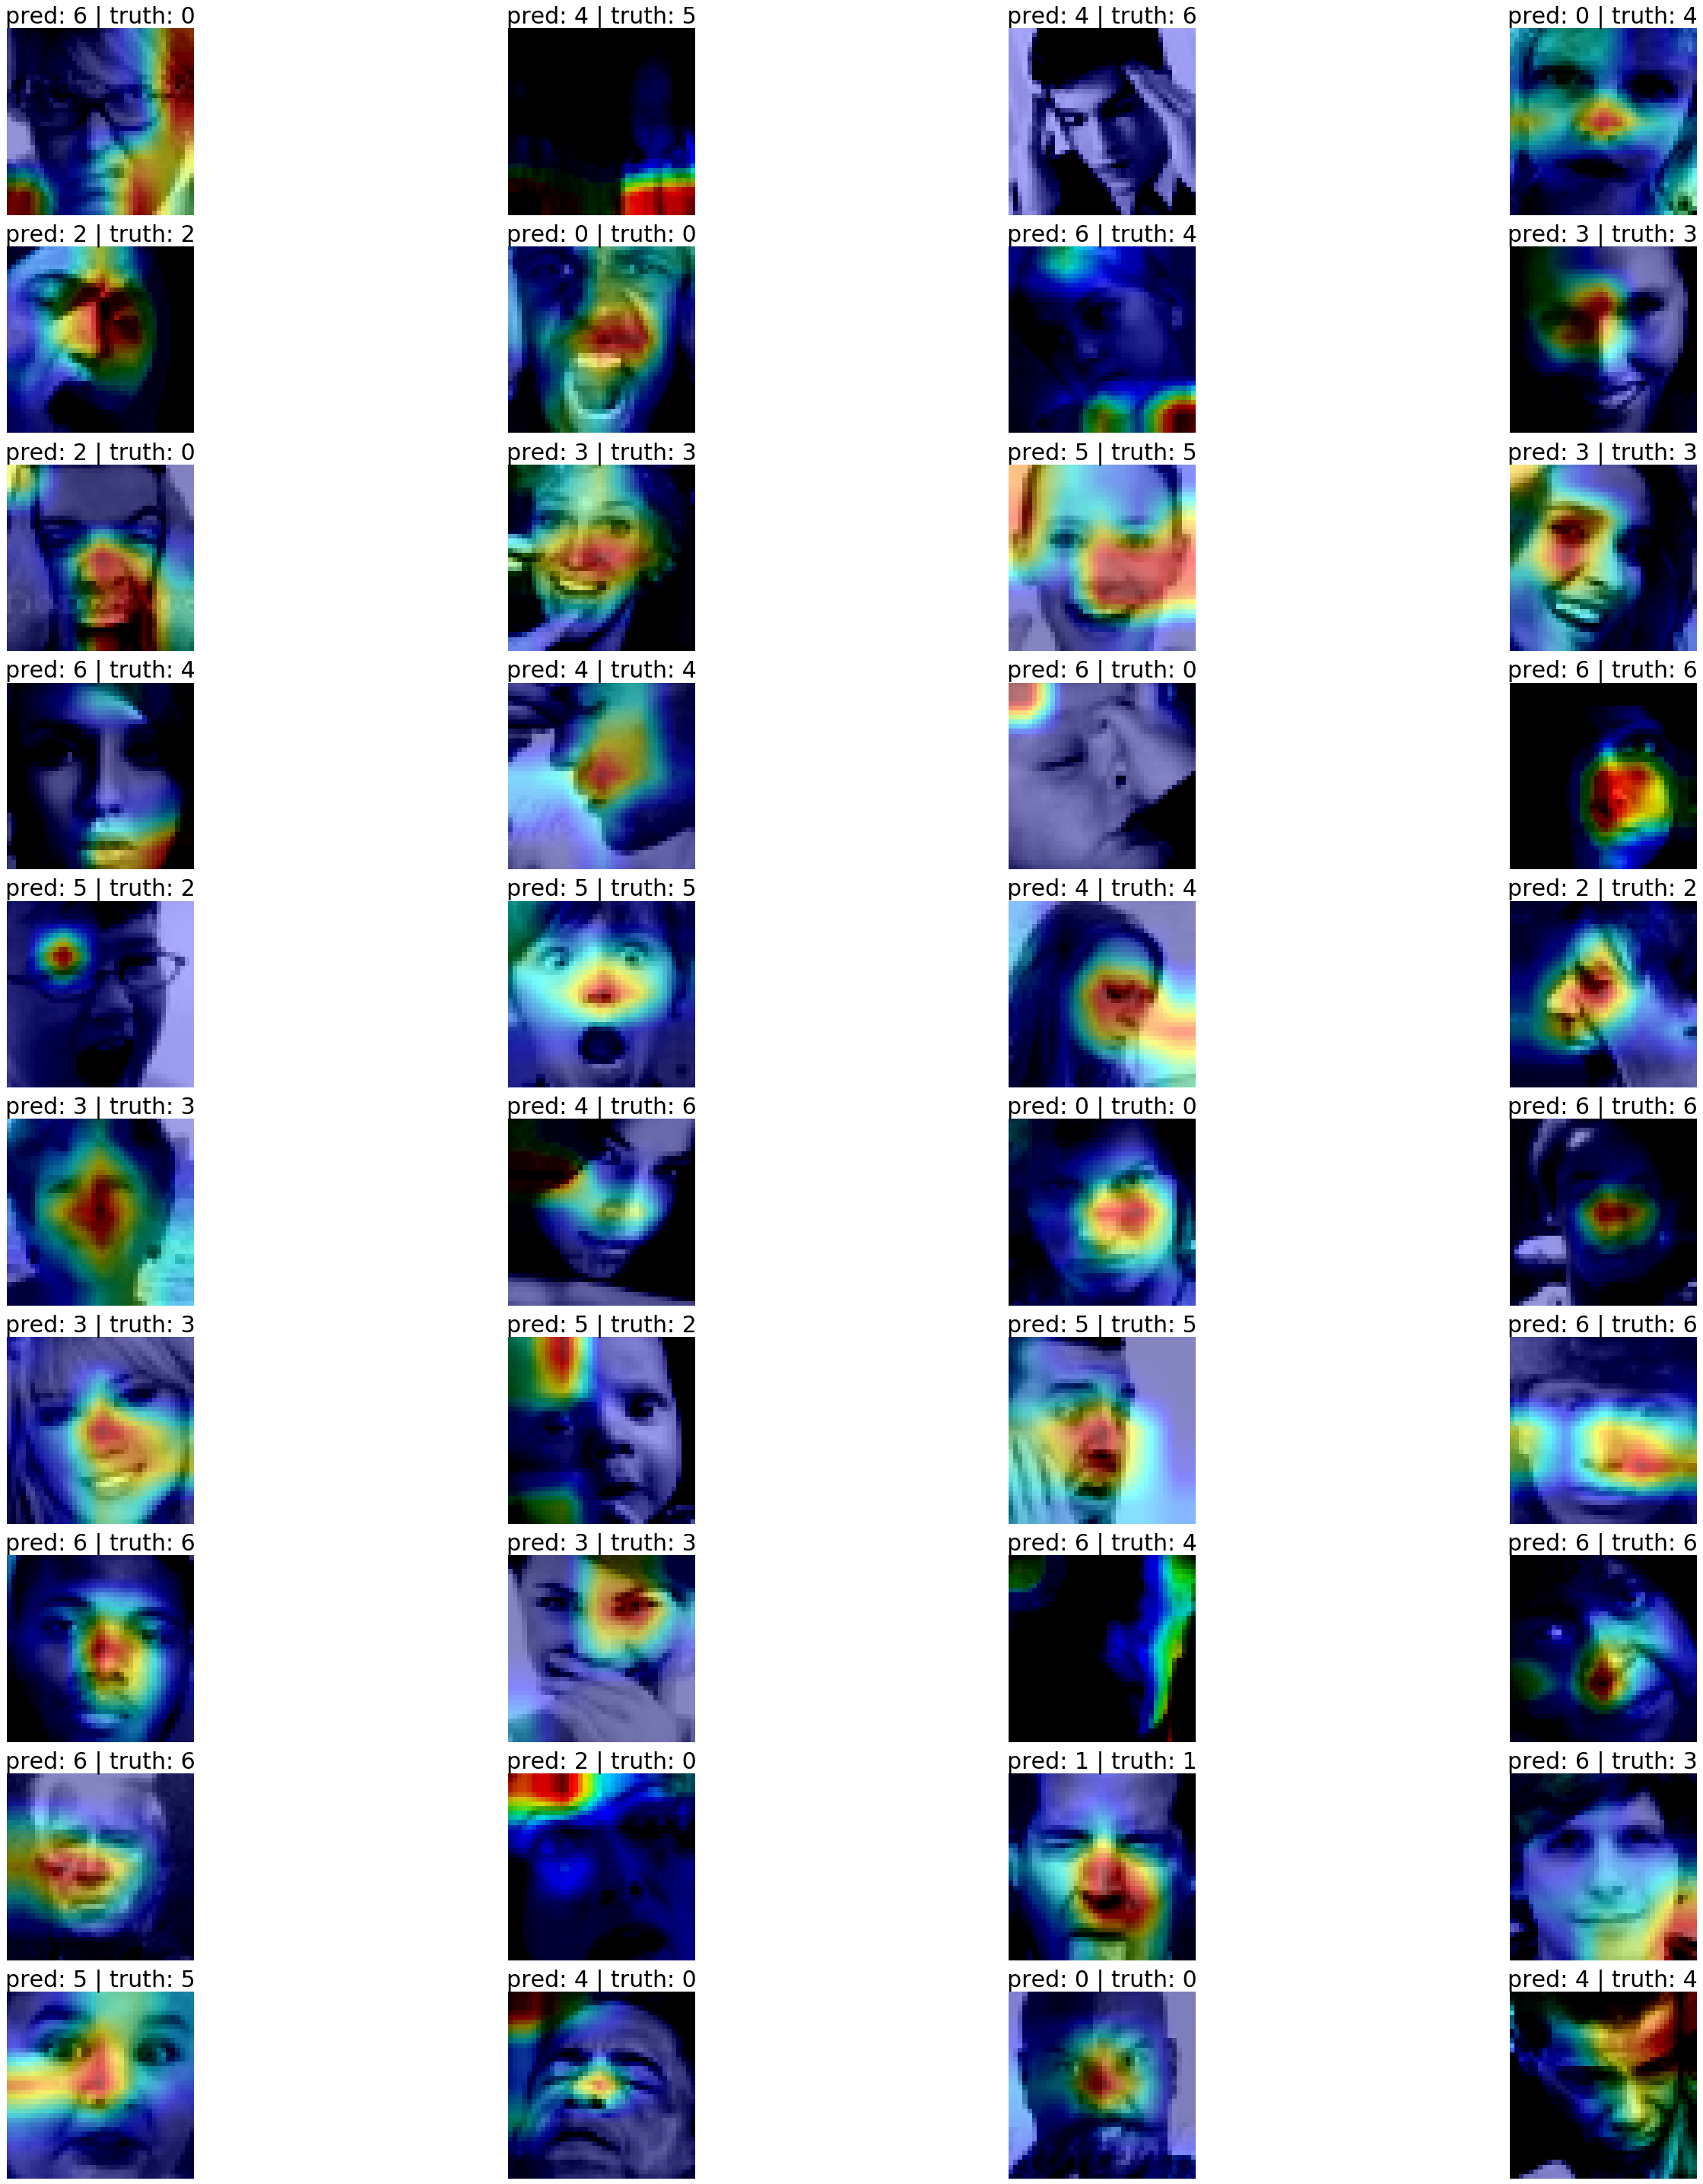

In [43]:
%matplotlib inline

#v1

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(test_model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])
features:  torch.Size([1, 512, 5, 5])
pooled grads:  torch.Size([1, 512, 1, 1])


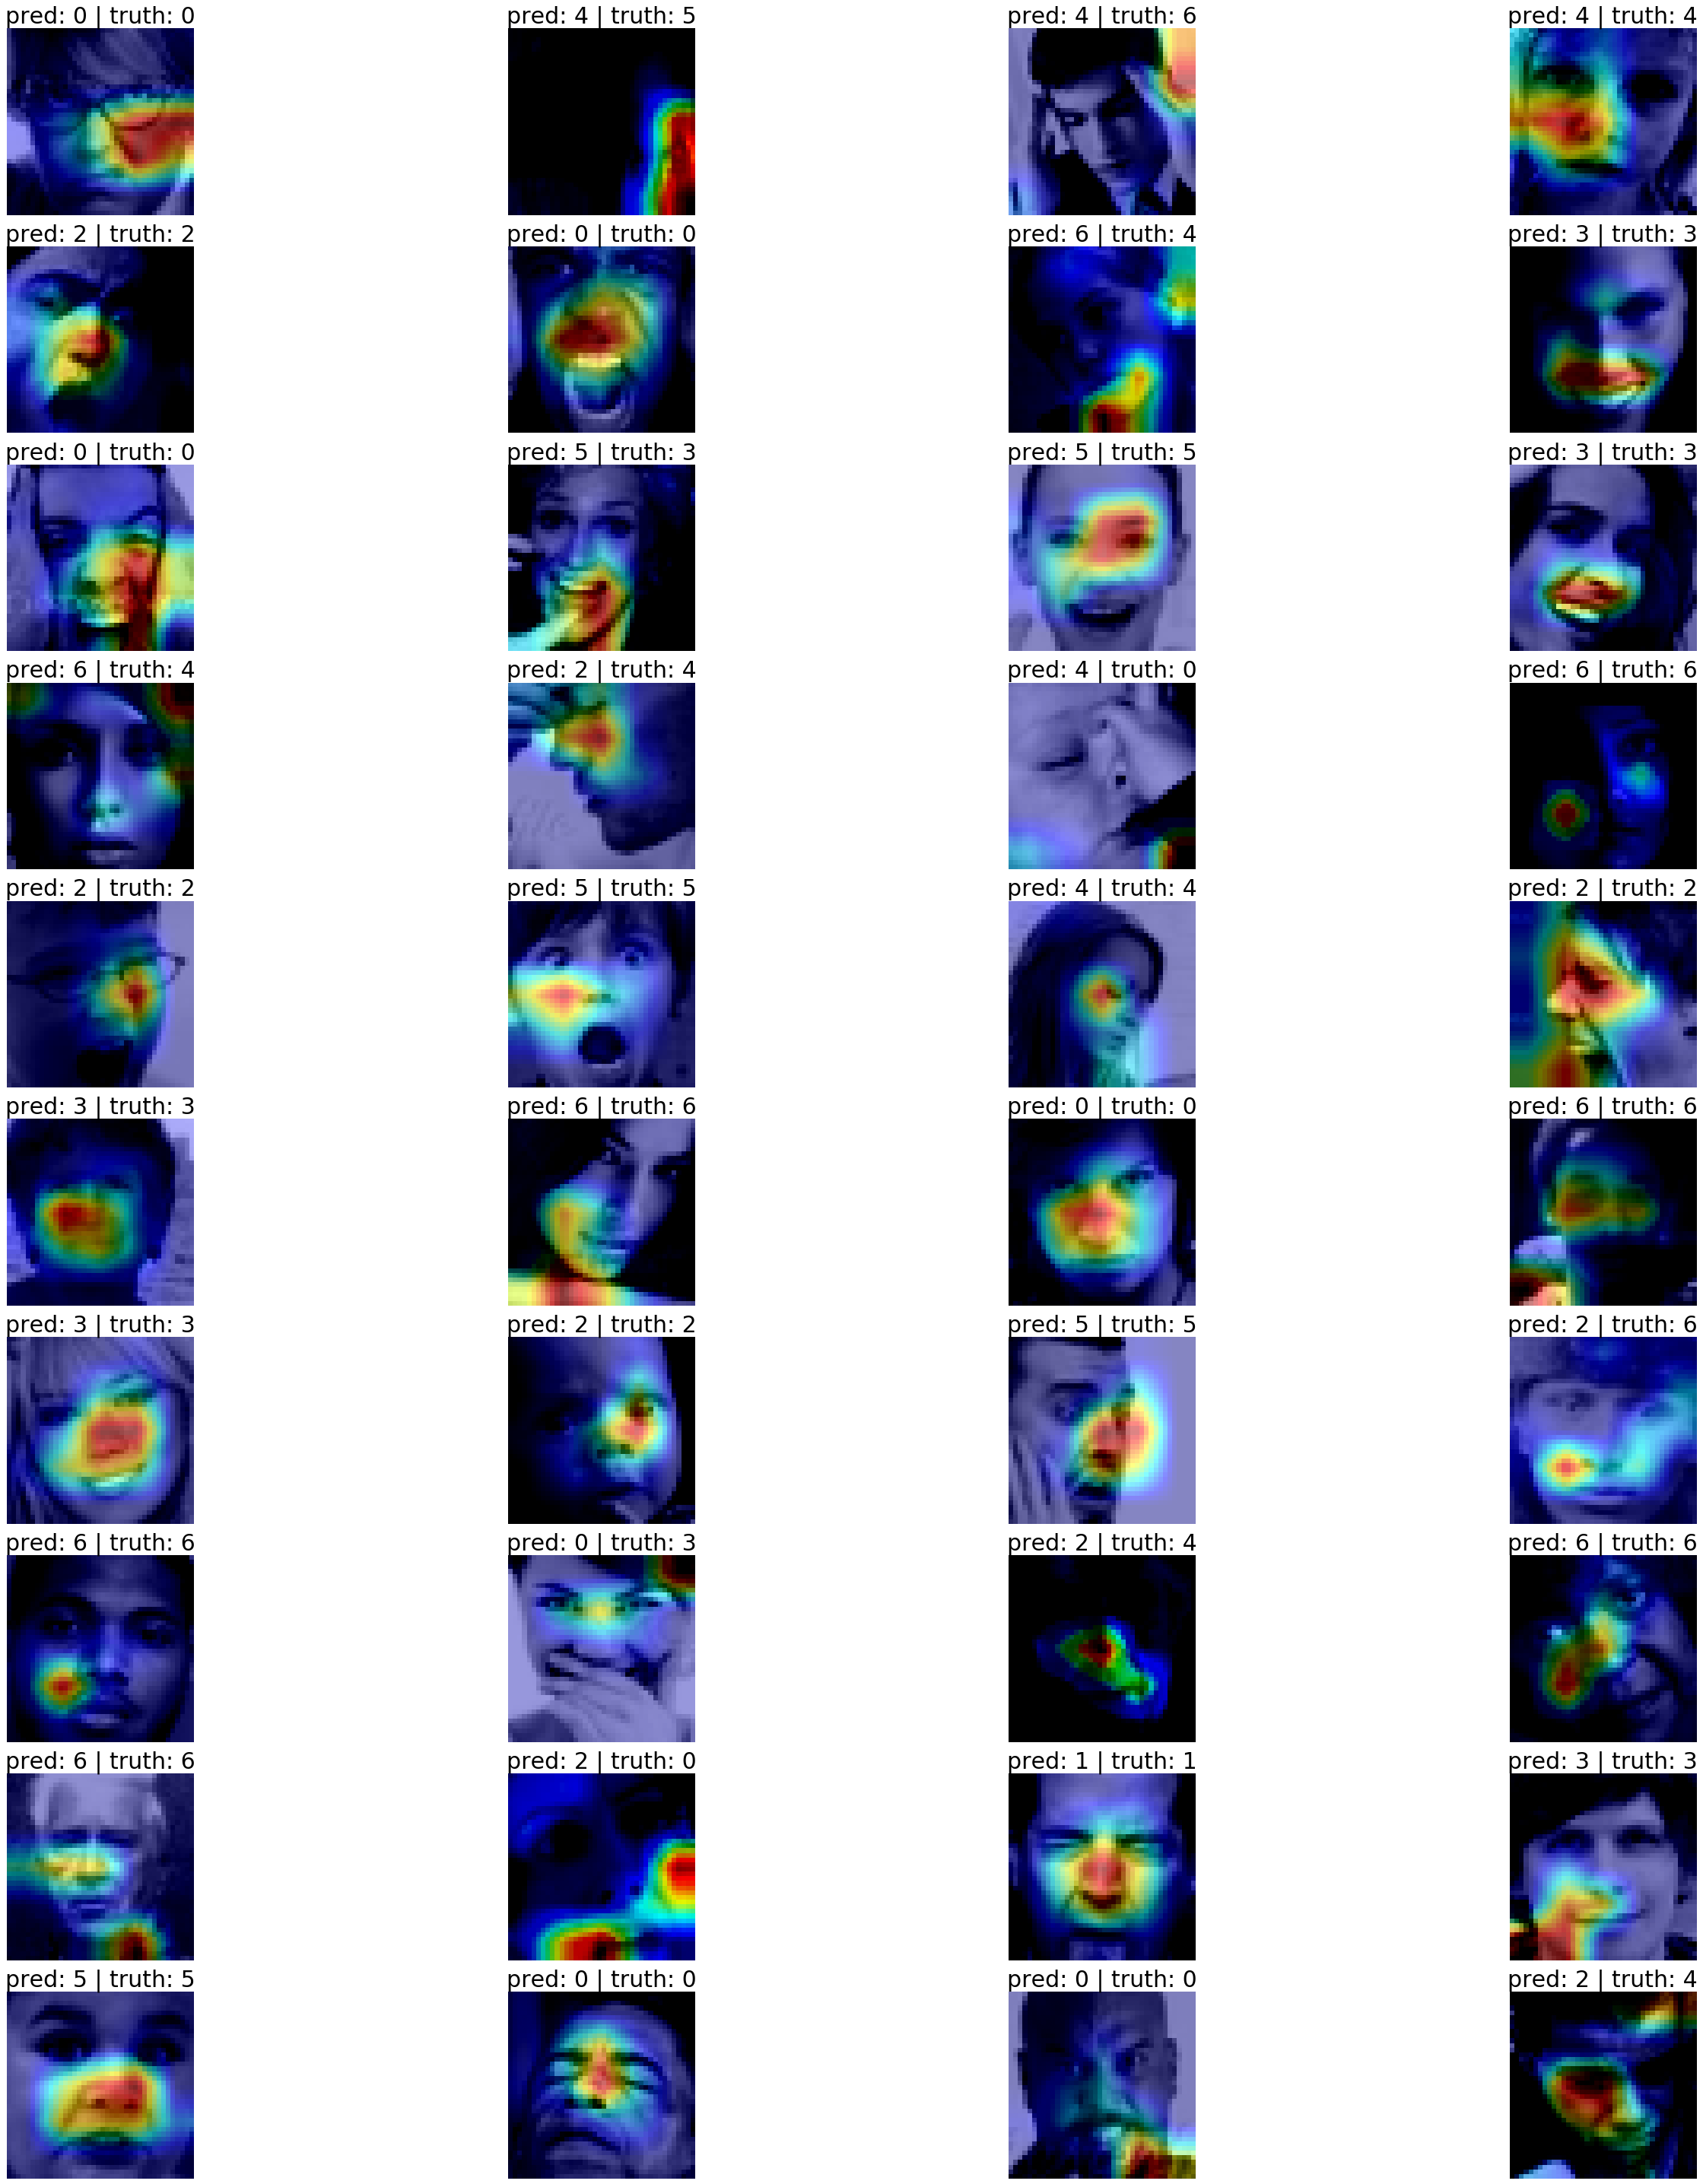

In [20]:
#v2

%matplotlib inline

images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
#         try:
        map, pred, truth, prob = attention(test_model, images[id], labels[id])
        axs[i,j].imshow(map)
        axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
        axs[i,j].axis('off')
        id = id + 1
#         except:
#             break

plt.tight_layout()
plt.show()